# Board-Interlocking And Corporate Performance on Company Performance

Name: Bingfeng Hu
CID: 01137798 
Date: 14/06/24


In [1]:
import pandas as pd # remove unncessary code structures here to show details
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import text_analysis as ta
import graph_analysis as ga
import regression_analysis as ra
import stata_setup
stata_setup.config("/usr/local/stata18", "se", splash=False)
from pystata import stata

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bingfeng93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bingfeng93/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Introduction and Context



Describe meaningful structure and what to do here 

Which datasets to work on

What the data structure is meaningful or not

Describe using a naive model. 



Given the potential large nature of graph, for companies and directors, 
looking at sub-industry - CIK details, doing sub sampling and looking at the two years

### 2. Graph structure analysis for graph interlocking

In this section, we will look at the board-interlocking structure of directors 

In [2]:
# set years
YEARS = [2022, 2023, 2024]

In [3]:
file_path = "raw_data/boardex_us_companies_full_data_2022_2024.csv"

filtered_data_df, boardex_data = ga.get_filtered_graph_data(file_path)
filtered_data_df.head()

,boardid,companyid,directorid,overlapyearstart,overlapyearend
0,401.0,2734400.0,601453.0,2020,NaN
1,401.0,3700766.0,601453.0,2023,NaN
2,401.0,61472.0,601453.0,2016,NaN
3,401.0,2055831.0,601453.0,2018,NaN
4,401.0,2065362.0,601453.0,2015,NaN


In [42]:
filtered_data_df.boardid.drop_duplicates().shape, filtered_data_df.directorid.drop_duplicates().shape

((749,), (10188,))

Link boardex data linking table to link with Compustat data for financial data.

In [4]:
boardex_gvkey_df = pd.read_csv("raw_data/USE_THIS_GVKEY_boardex_us_companies_keys.csv",
                               index_col= 0)

2. Create the graphs by year

Create a dictionary by year that's it, and get adjacency matrix

In [5]:
boardex_interlock_adj_dict = ga.create_adjacency_matrices_by_year(filtered_data_df, YEARS)

3. Calculate the graph statistics for each workflow

In [6]:
boardex_interlock_adj_dict.keys()

dict_keys([2022, 2023, 2024])

In [7]:
[x.shape for x in boardex_interlock_adj_dict.values()]

[(1694, 1694), (1059, 1059), (280, 280)]

Here we see that, if we model the connectivity in terms of directors bridiging affect, i.e. an edge when there are directors are simultaneously sitting on two different companies. We see that the directors that have such relationships for this strong connectivity are 1694, 1059 and 280 for 2022, 2023, and 2024 respectively. In particular, we see that there are only 280 directors, this shows that 2024 data is more incomplete compared to the other 2 years of study. This makes sense since 2024 is not complete yet.

4. Link the graph statistics back to the relevant companies

Then do averaging of these relevant statistics. If there are 0s that is fine also here.

In [36]:
graph_stat_df_final = ga.create_graph_statistics_df_by_year(boardex_interlock_adj_dict, YEARS)

Now we look at the graph statistics of the created graph by year

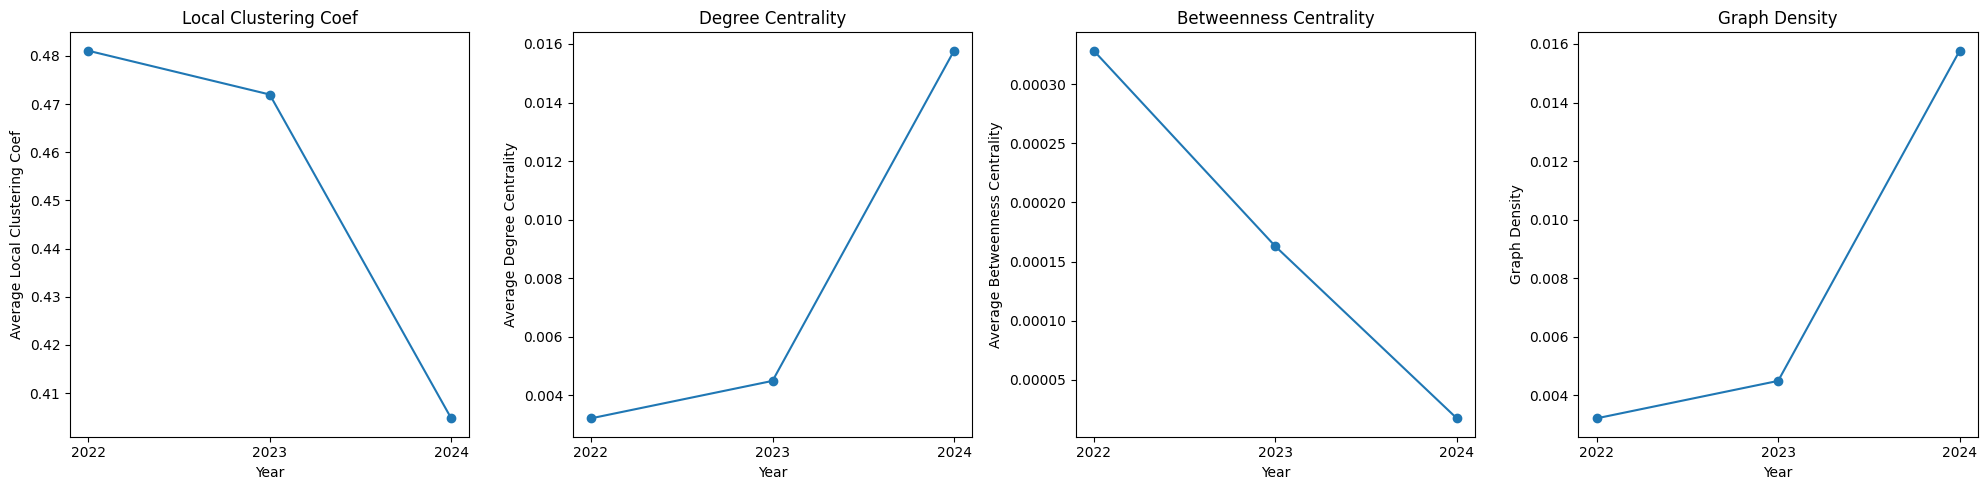

In [9]:
ga.plot_network_statistics(graph_stat_df_final)

Here, we can see that in terms of the average graph statistics for connectivity, we see that in terms of connectivity and local clustering, we can can see that the graph in 2022 and 2023 are less connected and more sparse compared to 2024. This is consistent with the comparison of the graphs density, we can see that graph in 2024 is much more connected compared to the graph in 2022 than 2023 due to this data incompleteness. As part of the analysis, we will drop 2024 as part of the overall regression analysis.

In the below, we use the graph statistics crated above at the director level, and create company level statistics instead to look at the social impact of board interlocking on the each company as a whole. This is done by averaging these director level node statistics, `local_clustering_coef`,`degree_centrality` and `betweenness_centrality` by company and year.

In [41]:
boardex_graph_stats_df = ga.create_company_level_statistics(boardex_data, boardex_gvkey_df, graph_stat_df_final)
boardex_graph_stats_df["companyid"].drop_duplicates().shape

(615,)

Here, we see that there are 615 companies overall for our analysis to analyse for the Boardex data over the ocurse of 3 years (2022, 2023, and 2024).

Next we visualise the graph data structure of these graphs over time. we can see that these graphs are consistent with the 

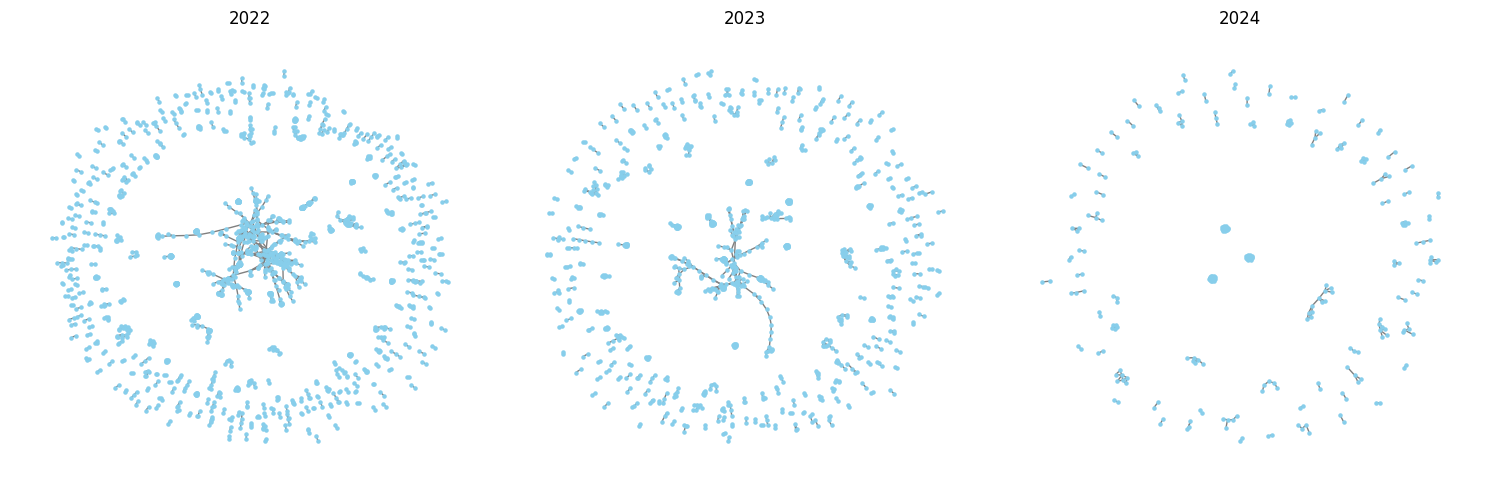

In [13]:
ga.plot_graphs_from_dict(boardex_interlock_adj_dict)

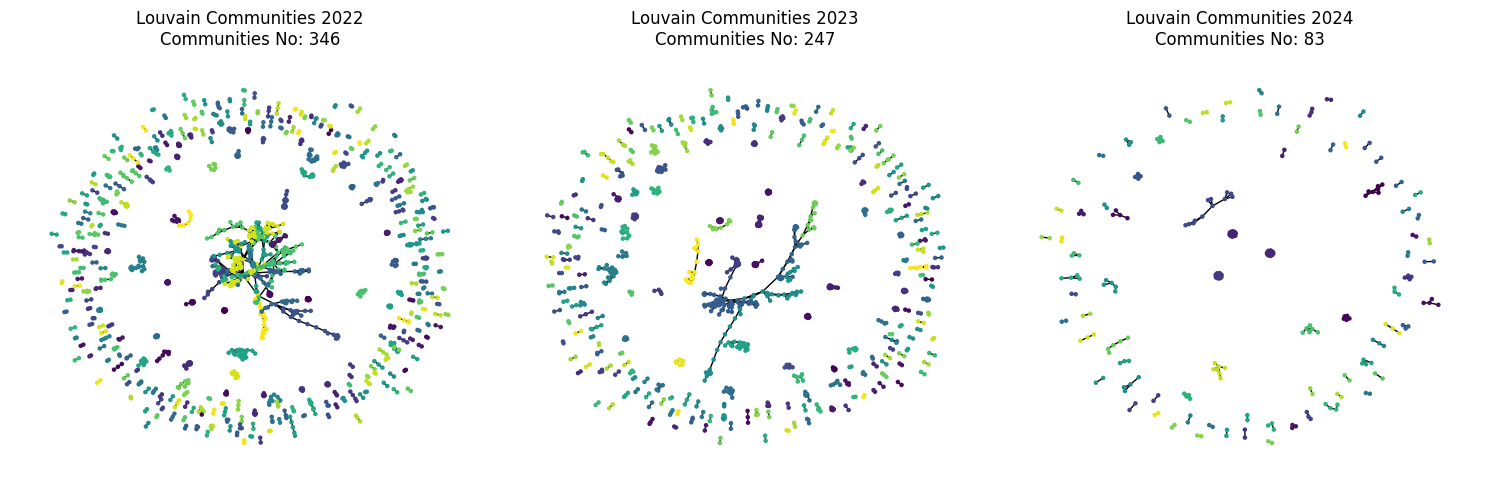

In [14]:
ga.plot_louvain_communities_from_dict(boardex_interlock_adj_dict)

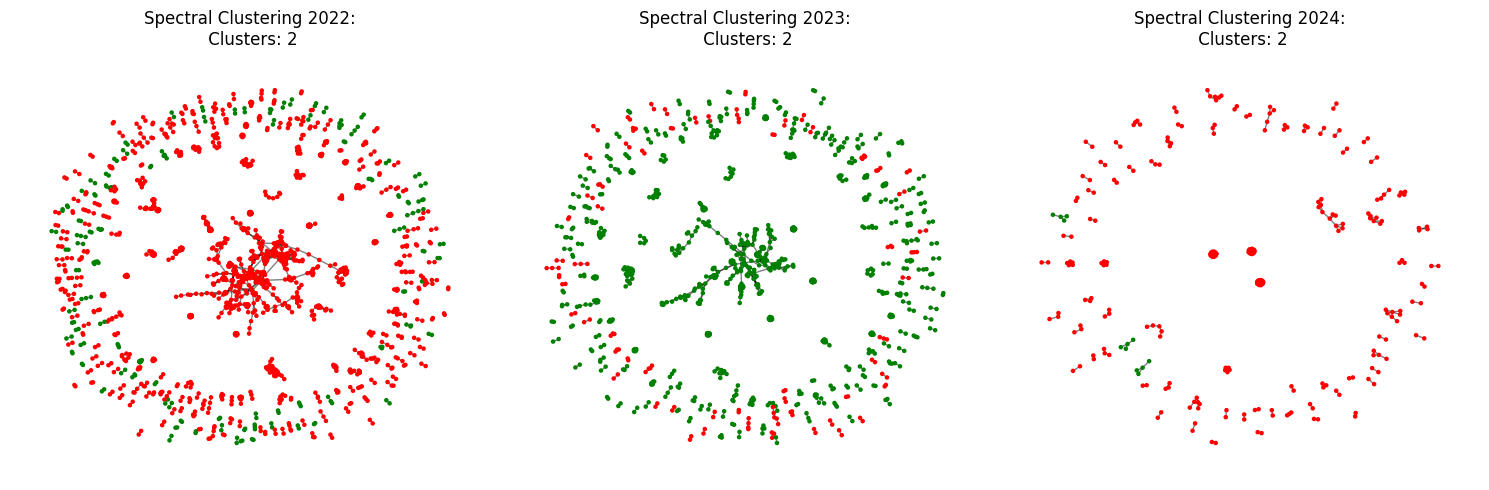

In [15]:
# visualise the graph densities in the above, for overview of content
ga.plot_spectral_clustering_from_dict(boardex_interlock_adj_dict, n_clusters=2, colour_map = ['red', 'green', 'blue', "orange", "yellow"])

Given that we see that there is incomplete data for 2024, I have decided for the final model, to only include relevant graph data for 2022 and 2023, and also combine the data I have available for 

### 3. Analysis of Text - Annual Report for Decisioning

In this section, we look at the 

Here we look at the reports where were filed in 2022, 2023, and 2024, which reflect the annual reports for the financial year 2021, 2022, and 2023 respectively.

#### LDA Analysis

First we analyse the information content of the annual report and business overview text by 

In [16]:
sec_10k_df = pd.read_json("raw_data/all_companies_report_annual_report_text_2022_2024.json")

In [17]:
sec_10k_df.head()[["companyName","periodOfReport","Text_1", "Text_1A"]]

,companyName,periodOfReport,Text_1,Text_1A
0,AMGEN INC,2023-12-31,Item 1. BUSINESS ##TABLE_END\n\nAmgen Inc. (i...,Item 1A. RISK FACTORS ##TABLE_END\n\nThis rep...
1,AMGEN INC,2022-12-31,Item 1. BUSINESS ##TABLE_END\n\nAmgen Inc. (i...,Item 1A. RISK FACTORS ##TABLE_END\n\nThis rep...
2,AMGEN INC,2021-12-31,Item 1. BUSINESS ##TABLE_END\n\nAmgen Inc. (i...,Item 1A. RISK FACTORS ##TABLE_END\n\nThis rep...
3,BALCHEM CORP,2023-12-31,"Item 1. Business (All amounts in thousands, e...",Item 1A. Risk Factors \n\nWe discuss our expe...
4,BALCHEM CORP,2022-12-31,"Item 1. Business (All amounts in thousands, e...",Item 1A. Risk Factors \n\nWe discuss our expe...


As part of training the LDA model, we first preprocess the text by removing stop words, and tokenising the each word using the Porter's stemmer to reduce all words into their root form (see commented out code). As this can take a while, we simply load the pre-processed file below with the cleaned text. This is then used to create a optimised dictionary and corpus to train and run our LDA model using the `gensim` package.

In [18]:
# take 6 minutes to run so skip this section
# sec_10k_df = ta.clean_tokenise_risk_assessment_txt(sec_10k_df)

In [19]:
docs_tok = pd.read_json("processed_data/all_companies_metadata_2022_2024_text_1A_cleaned.json")["Text_1A_data_cleaned"]
common_dictionary = Dictionary(docs_tok)
common_corpus = [common_dictionary.doc2bow(text) for text in docs_tok]

For the standard LDA we're implementing, we need to select the optimal number of topics here for our model. For choosing topics we use the frequentist approach to select the optimal number of topics, the performance metric used is often either the perplexity score like in Blei et al (2003) or coherence score (as shown by [Stackoverflow](https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda) and [Mathworks](https://uk.mathworks.com/help/textanalytics/ug/choose-number-of-topics-for-LDA-model.html)). We choose to select the optimal topics by coherence score (uncomment code below). This gave us a optimal number of 4 topics for our analysis, to train our LDA model.

In [20]:
# optimal_la_model, optimal_num_topics = ta.select_optimal_LDA_topic_number(docs_tok, common_corpus, common_dictionary, min_topics = 2, max_topics = 8)
# optimal_la_model.save("lda_mode.gensim")

In [21]:
optimal_num_topics = 4
lda_model = LdaMulticore.load("lda_model/risk_lda_model.gensim")

Next we look at the 

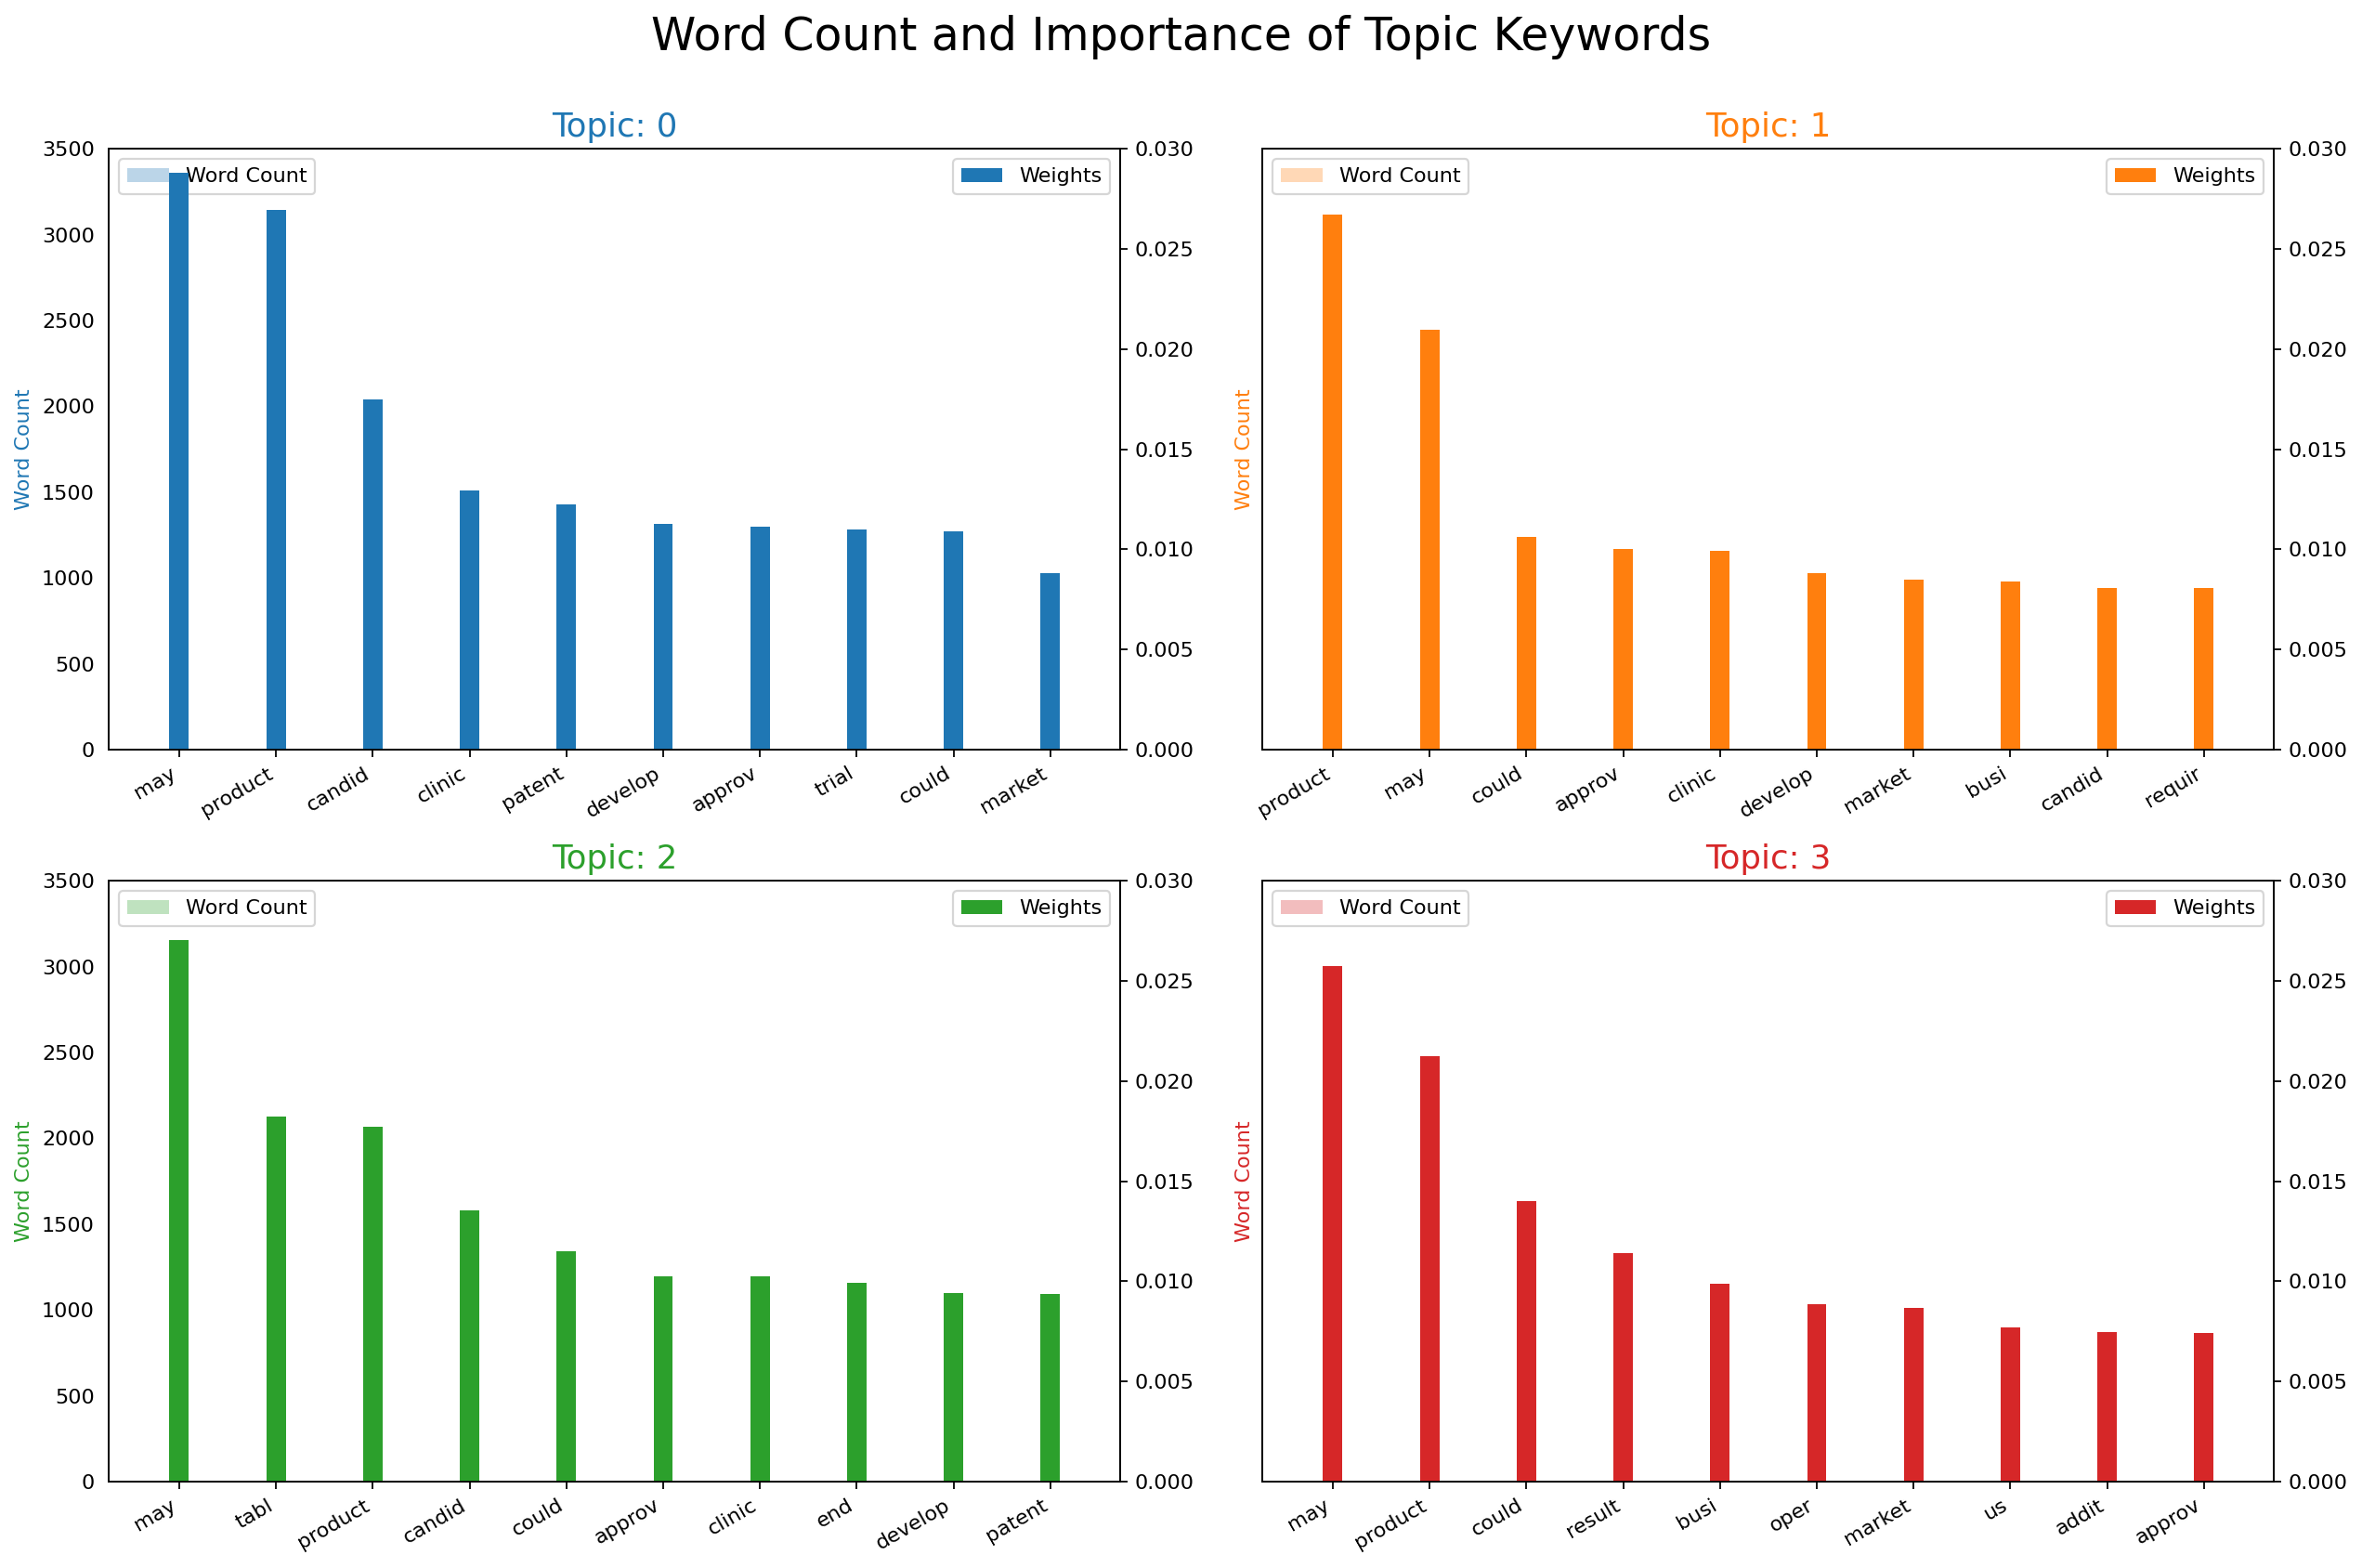

In [22]:
ta.plot_topic_compositions(lda_model, common_dictionary)

Add interpretations of the topics here over time

Given the interpretation of our topics, we then look at the 

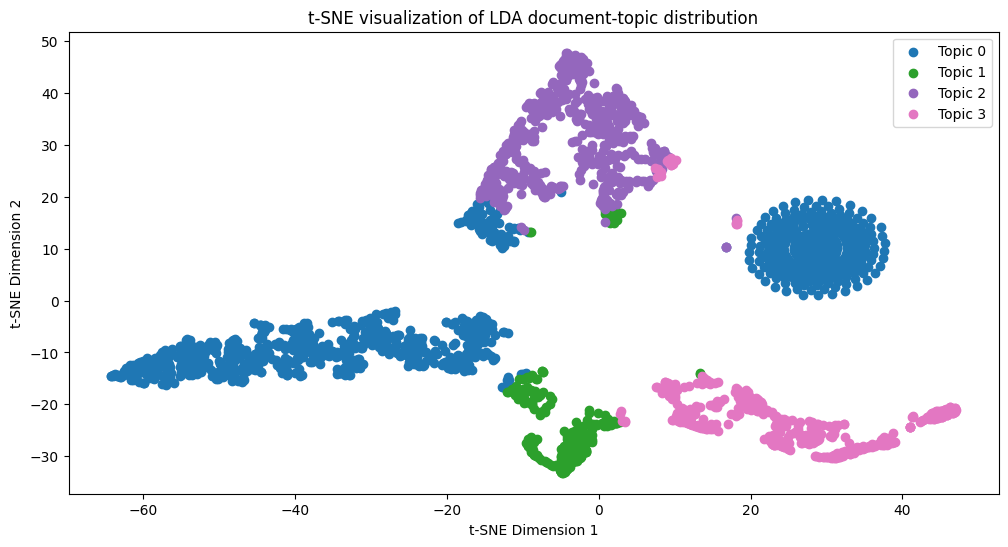

In [23]:
ta.plot_dominant_topic_distributions(lda_model, common_corpus)

In [24]:
sec_10k_df["topic_distribution"] = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in common_corpus]

In addition, the sentiment of the annual reports are useful. Hence we next evaluate the sentiments of the text over time, in particular we will focus on the business overview section of the annual report (section 1) as well as the risk overview section (section 1A). This gives us an overview of what the managers of outlook market sentiment on the pharmaceutical industry they operate in.

In [25]:
sec_10k_df = pd.read_json("processed_data/all_companies_report_annual_report_text_2022_2024_with_sentiments_topics.json")
sec_10k_df["report_year"] = pd.to_datetime(sec_10k_df["periodOfReport"]).apply(lambda x : x.year)

In [27]:
sec_10k_df[["cik", "report_year", "risk_sentiment", "business_overview_sentiment"]].head()

,cik,report_year,risk_sentiment,business_overview_sentiment
0,318154,2023,0,-1
1,318154,2022,-1,-1
2,318154,2021,0,1
3,9326,2023,-1,-1
4,9326,2022,-1,-1


Looking at the sentiments for the years 2021, 2022 and 2023.

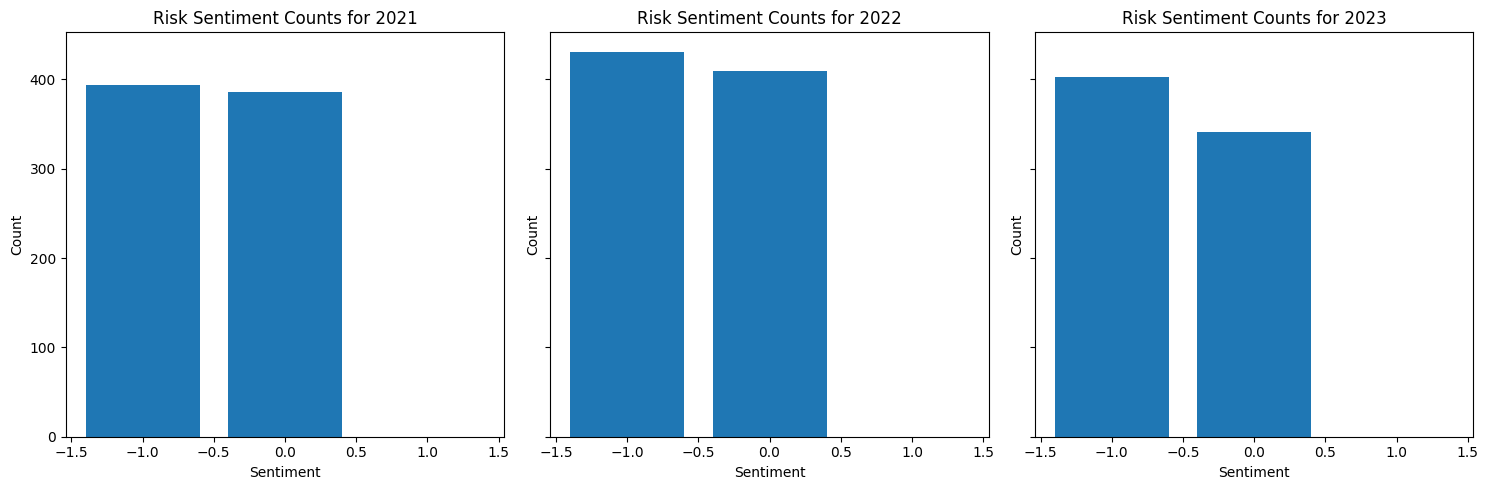

In [28]:
ta.plot_annual_report_sentiments(sec_10k_df, 'risk_sentiment', [2021, 2022, 2023] )

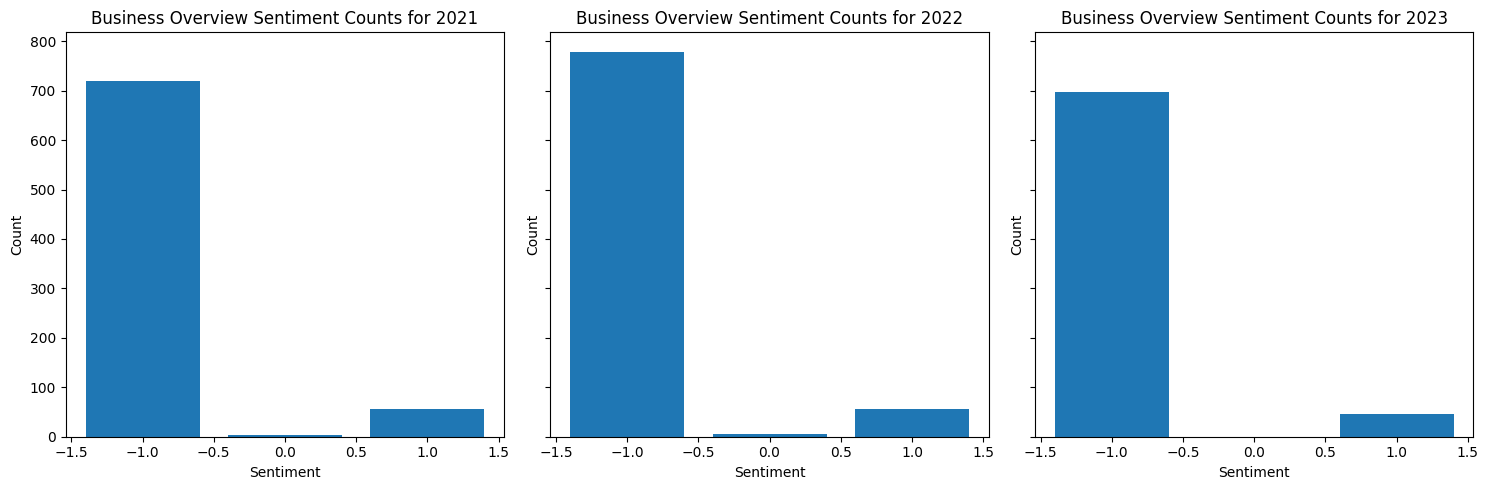

In [29]:
ta.plot_annual_report_sentiments(sec_10k_df, 'business_overview_sentiment', [2021, 2022, 2023] )

### 4. Combining the datasets together

Here we combine the information from the graph statistics, annual report text topic distributions and sentiments and financial data on pharmaceutical companies into a single table/dataframe to run panel regression.

In [30]:
# get the annual report compustat keys # first step
ar_key_df = pd.read_csv("raw_data/sec_gvkey_cik_us_pharma_2022_2024.csv", index_col = 0)
ar_key_df.head()

,gvkey,conm,datadate1,datadate2,cik,source,coname,fndate,lndate,n10k,n10k_nt,n10k_a,n10q,n10q_nt,n10q_a,ndef,n8k,ntot,flag
0,1602,AMGEN INC,1983-03-31,2023-12-31,318154.0,COMPN,AMGEN INC,1994-03-28,2024-06-04,32.0,0.0,3.0,95.0,0.0,4.0,92.0,308.0,2936.0,3.0
1,1979,BALCHEM CORP -CL B,1974-12-31,2023-12-31,9326.0,COMPN,BALCHEM CORP,1995-08-11,2024-05-24,31.0,0.0,2.0,91.0,0.0,5.0,38.0,194.0,1148.0,3.0
2,2086,BAXTER INTERNATIONAL INC,1950-12-31,2023-12-31,10456.0,COMPN,BAXTER INTERNATIONAL INC,1994-03-21,2024-06-05,34.0,1.0,3.0,97.0,1.0,5.0,52.0,276.0,2321.0,3.0
3,2403,BRISTOL-MYERS SQUIBB CO,1950-12-31,2023-12-31,14272.0,COMPN,BRISTOL MYERS SQUIBB CO,1994-03-15,2024-05-09,33.0,0.0,3.0,98.0,1.0,6.0,64.0,373.0,3304.0,3.0
4,2990,IMUNON INC,1983-09-30,2023-12-31,749647.0,COMPN,"IMUNON, INC.",1996-08-07,2024-05-22,38.0,1.0,9.0,96.0,3.0,9.0,41.0,300.0,1263.0,3.0


Next we load the compustat data (perhaps show what data is here)

In [31]:
# load the compustat data # second step - two functions is fine!!
compustat_data_df = pd.read_csv("raw_data/compustat_pharma_2021_2024_manual.csv", low_memory=False)

In [32]:
# use this final data to load everything so it is fine!! final merged data is everything
final_merged_data_df = ra.get_combined_financial_graph_ar_dataset(ar_key_df, sec_10k_df, 
                                                boardex_graph_stats_df, compustat_data_df)

final_merged_data_df.shape

(1136, 991)

### 5. Initial Regression model findings on Corporate Governance with Company Performance

As part of my final analysis, I will create 2 naive regression models to analyse factors driving company performance in biopharmaceutical firms using two panel regression analyses utilizing Random-effects Generalized Least Squares (GLS). To simplify the analysis, this will be done using Stata. Moreover I assume that Stata is the Standard Edition and installed in `/usr/local/stata18` folder. Otherwise the file path of the installed Stata programme can  can be edited in the `stata_setup.config` at the very top of the notebook file. The corresponding documentation can found on the [Stata python docs](https://www.stata.com/python/pystata18/stata.html#pystata.stata.run).

In [33]:
ra.run_regression_preprocess(final_merged_data_df, stata)

In [34]:
stata.run("xtreg epsfi sale local_clustering_coef degree_centrality betweenness_centrality graph_density risk_sentiment business_overview_sentiment risktopic1 risktopic2 risktopic3 , re")


Random-effects GLS regression                   Number of obs     =        949
Group variable: gvkey                           Number of groups  =        557

R-squared:                                      Obs per group:
     Within  = 0.0363                                         min =          1
     Between = 0.0236                                         avg =        1.7
     Overall = 0.0327                                         max =          2

                                                Wald chi2(10)     =      28.44
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0015

------------------------------------------------------------------------------
       epsfi | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        sale |   .0001764   .0000684     2.58   0.010     .0000425    .0003104
local_clus~f |   .3180965   1.085348     0.29   0.769    -1.8091

##### Model 1: Measuring Firm Performance by EPS

In the above model, which has an R-squared value of 0.025, assesses firm performance using "earnings per share" (epsfi) as the dependent variable. The analysis indicates a positive correlation between firm performance and the firm's sales (sale), which aligns with conventional business theory suggesting that higher sales volumes typically bolster profitability.

However, an unexpected result emerges from the variable representing the graph density of board interlocks (graph_density). Here, we observe a negative association with firm performance, implying potential drawbacks of tightly knit governance networks. While such interlocks might facilitate enhanced information exchange and resource sharing, they may also introduce conservatism and stifle innovation by overly solidifying existing networks and practices. This dynamic could potentially hinder a firm's agility and creativity, detrimentally affecting performance.

The intriguing nature of these results warrants further exploration into the possibility of an inverted U-shaped relationship between the density of board interlocks and firm performance. This hypothesis suggests that a moderate level of interlocks could be optimal, providing benefits without the accompanying drawbacks of excessive interconnection.


In [35]:
stata.run("xtreg rdipa sale local_clustering_coef degree_centrality betweenness_centrality graph_density risk_sentiment business_overview_sentiment risktopic1 risktopic2 risktopic3 , re")


Random-effects GLS regression                   Number of obs     =        943
Group variable: gvkey                           Number of groups  =        557

R-squared:                                      Obs per group:
     Within  = 0.0010                                         min =          1
     Between = 0.4742                                         avg =        1.7
     Overall = 0.3535                                         max =          2

                                                Wald chi2(10)     =     509.72
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

------------------------------------------------------------------------------
       rdipa | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        sale |  -.0132563   .0006193   -21.41   0.000    -.0144701   -.0120426
local_clus~f |   8.591799   15.93386     0.54   0.590    -22.637

##### Model 2: Measuring Firm Performance by R&D Investment

Model 2 achieves an R-squared value of 0.36 and focuses on the investment into research and development as the dependent variable (rdipa). Contrary to expectations, the findings from this model reveal a negative influence of sales on R&D investment. This counterintuitive result might indicate firms with higher sales are potentially allocating resources towards areas other than R&D. This may be due to prioritising short-term financial gains over long-term innovation.

Additionally, the impact of specific risk focus by managers, as indicated by the dummy variable risktopic2, is found to be negatively associated with R&D investment, compared to the reference group risktopic4. This outcome accentuates the complex ways in which different risk narratives, as embedded in corporate communications, shape managerial attitudes and strategic decisions regarding innovation and risk-taking.

The nuanced effects of sales and strategic risk orientation on R&D investments highlight the need for a deeper understanding of the strategic choices that drive firm behaviour in the biopharmaceutical industry. Future analyses will delve into these relationships more profoundly to decipher the strategic underpinnings and potential causal mechanisms at play.


### 6. Research Directions and Next steps

We have found some interesting initial findings, from the initial EDA on board interlocks from graph data, decisioning topics from annual reports, as factors which impacts firm performance. There are a few limitations to the approach above, in particular, I have only included 2 years worth of data in the panel regression, this could potentially raise doubt on the validity of the results presented above. Hence the next steps will focus on enhancing the enhance the robustness of the findings. This allow for further contributions to the research on corporate governance, strategic decision-making, and innovation in the high-stakes context of the biopharmaceutical industry.

First, deeper further research will delve into the specific qualities of board interlocks, such as the diversity of expertise and industry representation among interlocked boards, to understand how these attributes influence the decision-making and innovation capacity of firms. Second, further analysis can done on managerial focus by analysing their attitudes on industry sentiment and risk focus/oritentation, in corporate communication documents such as annual reports. Using more advanced NLP and topic modelling techniques, augmented by Bayesian methods, will provide deeper insights into how these factors correlate with strategic choices and performance outcomes. In addition applying Bayesian analysis overall into analysis of graphs and machine learning will refine the understanding of complex interdependencies and predictive capabilities concerning firm performance. As we see, there is very limited Bayesian analysis done in the initial naive modelling workflow.

1. Meaningful graph cluster - from EDA structure
2. Topic modelling from the regression
3. Add more data to enrich the details, given the limited interpretation, - describe features missing and add this here.
    - Add more years as needed for the workflow

Bayesian enrichment of topics - given the structure we have.